# TD : classification d'image avec un CNN

This notebook is part of the course given by J. Velcin on Deep Learning at the University of Lyon 2.

Les données sont là :

https://www.kaggle.com/code/tamircip/simple-fruit-detector-by-cnn/data

## Création du dataset

In [1]:
import tensorflow as tf
import os

In [14]:
tf.__version__

'2.10.0'

In [2]:
list_dir = os.listdir('datasets/fruits/')
data_raw = {}
for l in list_dir:
    data_raw[l] = []

data_raw.keys()

dict_keys(['apple', 'strawberry', 'lemon', 'mango', 'broccoli', 'grape', 'orange'])

In [3]:
#full_dataset = []
#classes = []
#for k in data_raw:
#    full_dataset += data_raw[k]
#    classes += [k]*len(data_raw[k])
#dataset = tf.data.Dataset.from_tensor_slices(full_dataset)

In [4]:
classNames = list(data_raw.keys())
print(classNames)

['apple', 'strawberry', 'lemon', 'mango', 'broccoli', 'grape', 'orange']


In [5]:
#.map(load_images,
def load_image_classe(filename):
    label = tf.strings.split(filename, sep='/')[-2]    
    oneHot = label == classNames
    classe = tf.argmax(oneHot)
    raw = tf.io.read_file(filename)
    image = tf.image.decode_png(raw, channels=3)
    image = tf.image.resize(image, (32, 32)) / 255.0
    return (image, classe)

list_dir = os.listdir('datasets/fruits/')
data_paths = []
data_class = []
for l in list_dir:
    list_files = os.listdir('datasets/fruits/' + l + "/")
    for f in list_files:
        ext = os.path.splitext(f)[-1].lower()
        if ((ext == ".png") or (ext == ".jpg") or (ext == ".jpeg")):
            data_paths.append('datasets/fruits/' + l + "/" + f)
            data_class.append(l)

In [6]:
num_train = len(data_paths)

In [10]:
dataset = tf.data.Dataset.from_tensor_slices(data_paths)

In [11]:
dataset

<TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [12]:
from tensorflow.data import AUTOTUNE

BS = 64
#NUM_STEPS = 1000

dataset = (dataset
    .shuffle(1024)
    .map(load_image_classe, num_parallel_calls=AUTOTUNE)
    .cache()
    .repeat()
    .batch(BS)
    .prefetch(AUTOTUNE)
)

In [13]:
dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

## Architecture deep

In [13]:
# architecture proposée par T. Ciprut
# cf. : https://www.kaggle.com/code/tamircip/simple-fruit-detector-by-cnn

from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, GlobalMaxPooling2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Model

def cnn_forfruits():
    i = Input(shape=(32,32,3))
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(i)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.2)(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.2)(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.2)(x)
    x = GlobalMaxPooling2D()(x)
    x = Flatten()(x)
    x = Dropout(0.2)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(7, activation='softmax')(x)
    return Model(i, x)

model = cnn_forfruits()

In [14]:
# first attempts

model.compile(
  optimizer='RMSprop',
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy'])

In [17]:
step_size = num_train//BS
print(step_size)

104


In [18]:
tf.data.experimental.cardinality(dataset)

<tf.Tensor: shape=(), dtype=int64, numpy=-1>

In [19]:
model.fit(
    dataset,
    batch_size = 32,
    epochs=100,
    steps_per_epoch=step_size
)

Epoch 1/100


2022-10-28 09:13:01.609172: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-10-28 09:13:01.865856: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


104/104 [==============================] - 6s 35ms/step - loss: 2.1687 - accuracy: 0.4970
Epoch 2/100
104/104 [==============================] - 2s 15ms/step - loss: 1.8271 - accuracy: 0.3691
Epoch 3/100
104/104 [==============================] - 2s 15ms/step - loss: 1.9926 - accuracy: 0.2351
Epoch 4/100
104/104 [==============================] - 2s 16ms/step - loss: 1.8268 - accuracy: 0.2927
Epoch 5/100
104/104 [==============================] - 2s 15ms/step - loss: 1.7977 - accuracy: 0.3166
Epoch 6/100
104/104 [==============================] - 2s 15ms/step - loss: 1.8676 - accuracy: 0.3359
Epoch 7/100
104/104 [==============================] - 2s 15ms/step - loss: 1.8980 - accuracy: 0.2853
Epoch 8/100
104/104 [==============================] - 2s 15ms/step - loss: 1.8126 - accuracy: 0.3005
Epoch 9/100
104/104 [==============================] - 2s 15ms/step - loss: 1.8661 - accuracy: 0.2721
Epoch 10/100
104/104 [==============================] - 2s 15ms/step - loss: 1.7868 - accuracy

KeyboardInterrupt: 

In [13]:
# from: https://towardsdatascience.com/how-to-split-a-tensorflow-dataset-into-train-validation-and-test-sets-526c8dd29438

def get_dataset_partitions_tf(ds, ds_size, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    if shuffle:
        # Specify seed to always have the same split distribution between runs
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

(trainset, valset, testset) = get_dataset_partitions_tf(dataset, num_train)

In [14]:
num_train_set = len(list(trainset))
print(num_train_set)
step_size_train = num_train_set//BS

2022-10-26 17:39:51.289032: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


5350


In [15]:
model_2 = cnn_forfruits()
model_2.compile(
  optimizer='Adam',
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy'])

In [16]:
model_2.fit(
    trainset,
    validation_data=valset,
    batch_size = 32,
    epochs=200,
    steps_per_epoch=step_size_train
)

Epoch 1/200


2022-10-26 17:40:00.373043: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


80/83 [===========================>..] - ETA: 0s - loss: 2.6441 - accuracy: 0.2129

2022-10-26 17:40:03.171334: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


83/83 [==============================] - 15s 165ms/step - loss: 2.6354 - accuracy: 0.2112 - val_loss: 2.1205 - val_accuracy: 0.1506
Epoch 2/200
83/83 [==============================] - 9s 110ms/step - loss: 1.8567 - accuracy: 0.2982 - val_loss: 2.6713 - val_accuracy: 0.1404
Epoch 3/200
83/83 [==============================] - 9s 113ms/step - loss: 1.7397 - accuracy: 0.3334 - val_loss: 2.7362 - val_accuracy: 0.2055
Epoch 4/200
83/83 [==============================] - 9s 111ms/step - loss: 1.5738 - accuracy: 0.4091 - val_loss: 2.4835 - val_accuracy: 0.2367
Epoch 5/200
83/83 [==============================] - 8s 97ms/step - loss: 1.4993 - accuracy: 0.4509 - val_loss: 2.4571 - val_accuracy: 0.2268
Epoch 6/200
83/83 [==============================] - 9s 107ms/step - loss: 1.5229 - accuracy: 0.4196 - val_loss: 1.8232 - val_accuracy: 0.3190
Epoch 7/200
83/83 [==============================] - 8s 103ms/step - loss: 1.4150 - accuracy: 0.4765 - val_loss: 1.4859 - val_accuracy: 0.4431
Epoch 8/200

## Prédiction avec le modèle

In [17]:
testGen = iter(testset)

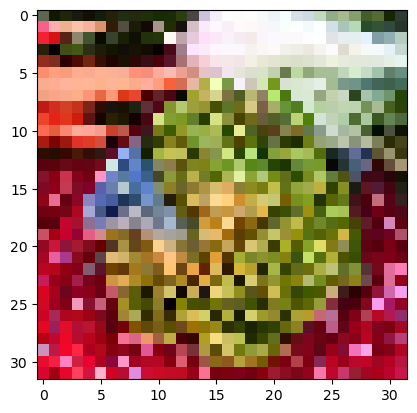

In [18]:
import matplotlib.pyplot as plt

next_ex = testGen.get_next()
im_test1 = next_ex[0][1]
plt.imshow(im_test1)
plt.show()

In [19]:
p = model_2.predict(next_ex[0])

2/2 [==============================] - 0s 4ms/step


2022-10-26 17:52:09.771785: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [20]:
p[1]

array([1.7131143e-03, 2.8854184e-04, 7.7329350e-05, 6.9396345e-05,
       9.9767154e-01, 1.7934456e-04, 7.1081274e-07], dtype=float32)

In [21]:
classNames

['apple', 'strawberry', 'lemon', 'mango', 'broccoli', 'grape', 'orange']

In [22]:
next_ex[1][1]

<tf.Tensor: shape=(), dtype=int64, numpy=4>